This is a demo illustrating an application of the OS2D method on one image.
Demo assumes the OS2D code is [installed](./INSTALL.md).

In [2]:
# ! pip install yacs

In [1]:
import os
import argparse
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms

from os2d.modeling.model import build_os2d_from_config
from os2d.config import cfg
import  os2d.utils.visualization as visualizer
from os2d.structures.feature_map import FeatureMapSize
from os2d.utils import setup_logger, read_image, get_image_size_after_resize_preserving_aspect_ratio

logger = setup_logger("OS2D")

In [2]:
# use GPU if have available
cfg.is_cuda = torch.cuda.is_available()

Download the trained model (is the script does not work download from [Google Drive](https://drive.google.com/open?id=1l_aanrxHj14d_QkCpein8wFmainNAzo8) and put to models/os2d_v2-train.pth). See [README](./README.md) to get links for other released models.

In [3]:
# ! ./os2d/utils/wget_gdrive.sh models/os2d_v2-train.pth 1l_aanrxHj14d_QkCpein8wFmainNAzo8

In [4]:
cfg.init.model = "models/os2d_v2-train.pth"
net, box_coder, criterion, img_normalization, optimizer_state = build_os2d_from_config(cfg)

2021-03-02 23:47:03,864 OS2D INFO: Building the OS2D model
2021-03-02 23:47:05,804 OS2D INFO: Creating model on one GPU
2021-03-02 23:47:05,842 OS2D INFO: Reading model file models/os2d_v2-train.pth
2021-03-02 23:47:05,930 OS2D INFO: Loaded complete model from checkpoint
2021-03-02 23:47:05,930 OS2D INFO: Cannot find 'optimizer' in the checkpoint file. Initializing optimizer from scratch.
2021-03-02 23:47:05,936 OS2D INFO: OS2D has 139 blocks of 10169478 parameters (before freezing)
2021-03-02 23:47:05,937 OS2D INFO: OS2D has 139 blocks of 10169478 trainable parameters


Get the image where to detect and two class images.

In [5]:
class_images =[]

class_ids=[]



In [6]:
import glob

#..........................................................
blue_pallet_trucks = glob.glob("./loco_test_images/templateimages/pallet_truck_folders/*")

for image in blue_pallet_trucks:
    class_images.append(read_image(image))
    class_ids.append(0)
    
electric_pallet_trucks = glob.glob("./loco_test_images/templateimages/electric_pallet_truck/*")

for image in electric_pallet_trucks:
    class_images.append(read_image(image))
    class_ids.append(0)
    
    
hand_pallet_trucks = glob.glob("./loco_test_images/templateimages/pallet_truck_folders/*")

for image in hand_pallet_trucks:
    class_images.append(read_image(image))
    class_ids.append(0)
    
    
#........................................................    
forklifts = glob.glob("./loco_test_images/templateimages/forklifts/*")

for image in forklifts:
    class_images.append(read_image(image))
    class_ids.append(1)
    
#.......................................................
pallets = glob.glob("./loco_test_images/templateimages/pallets/palletscropped/*")

for image in pallets:
    class_images.append(read_image(image))
    class_ids.append(2)
    
#............................................................
small_carrier_loads = glob.glob("./loco_test_images/templateimages/small_carrier_loads/cropped_images/*")

for image in small_carrier_loads:
    class_images.append(read_image(image))
    class_ids.append(3)
    
#.........................................................

stillages = glob.glob("./loco_test_images/templateimages/stillages/croppedimages/*")

for image in stillages:
    class_images.append(read_image(image))
    class_ids.append(4)
    


In [7]:
print(len(class_ids))
print(class_images)
print(class_ids)

49
[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x16ABCA1FFC8>, <PIL.WebPImagePlugin.WebPImageFile image mode=RGB size=750x750 at 0x16ABCADFB48>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=848x1500 at 0x16ABC962848>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=223x226 at 0x16ABCAE0688>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1500x1268 at 0x16ABCAE0888>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=249x386 at 0x16ABCAE0A08>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=119x110 at 0x16ABCAE0C08>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=202x250 at 0x16ABCAE0D88>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=136x222 at 0x16ABCAE0E88>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=154x149 at 0x16ABC9628C8>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=164x214 at 0x16ABCAED148>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x16ABCAED2C8>, <PIL.WebP

In [8]:
input_image = read_image("./loco_test_images/test_images/431256,8865.jpg")
# class_images = [read_image("./loco_test_images/test_cropped/forklift1.jpg"),
#                 read_image("./loco_test_images/test_cropped/forklift2.jpg"),
#                read_image("./loco_test_images/test_cropped/pallet_truck1.jpg"),
#                read_image("./loco_test_images/test_cropped/pallet_turck2.jpg"),
#                read_image("./loco_test_images/test_cropped/pallet_truck3.jpg")]
# class_ids = [0,0,1,1, 1]

Use torchvision to convert images to torch.Tensor and to apply normalization.

In [9]:
transform_image = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(img_normalization["mean"], img_normalization["std"])
                      ])

Prepare the input image

In [10]:
h, w = get_image_size_after_resize_preserving_aspect_ratio(h=input_image.size[1],
                                                               w=input_image.size[0],
                                                               target_size=1500)
input_image = input_image.resize((w, h))

input_image_th = transform_image(input_image)
input_image_th = input_image_th.unsqueeze(0)
if cfg.is_cuda:
    input_image_th = input_image_th.cuda()


Prepare the class images

In [11]:
class_images_th = []
for class_image in class_images:
    h, w = get_image_size_after_resize_preserving_aspect_ratio(h=class_image.size[1],
                                                               w=class_image.size[0],
                                                               target_size=cfg.model.class_image_size)
    class_image = class_image.resize((w, h))

    class_image_th = transform_image(class_image)
    if cfg.is_cuda:
        class_image_th = class_image_th.cuda()

    class_images_th.append(class_image_th)

Run the network with one command

In [12]:
with torch.no_grad():
     loc_prediction_batch, class_prediction_batch, _, fm_size, transform_corners_batch = net(images=input_image_th, class_images=class_images_th)

RuntimeError: CUDA out of memory. Tried to allocate 748.00 MiB (GPU 0; 4.00 GiB total capacity; 2.07 GiB already allocated; 312.98 MiB free; 2.62 GiB reserved in total by PyTorch)

Alternatively one can run the stages of the model separatly, which is convenient, e.g., for sharing class feature extraction between many input images.

In [10]:
# with torch.no_grad():
#     feature_map = net.net_feature_maps(input_image_th)

#     class_feature_maps = net.net_label_features(class_images_th)
#     class_head = net.os2d_head_creator.create_os2d_head(class_feature_maps)

#     loc_prediction_batch, class_prediction_batch, _, fm_size, transform_corners_batch = net(class_head=class_head,
#                                                                                             feature_maps=feature_map)


Convert image organized in batches into images organized in pyramid levels. Not needed in the demo, but essential for multiple images in a batch and multiple pyramid levels.

In [9]:

image_loc_scores_pyramid = [loc_prediction_batch[0]]
image_class_scores_pyramid = [class_prediction_batch[0]]
img_size_pyramid = [FeatureMapSize(img=input_image_th)]
transform_corners_pyramid = [transform_corners_batch[0]]


Decode network outputs into detection boxes

In [10]:
boxes = box_coder.decode_pyramid(image_loc_scores_pyramid, image_class_scores_pyramid,
                                           img_size_pyramid, class_ids,
                                           nms_iou_threshold=cfg.eval.nms_iou_threshold,
                                           nms_score_threshold=cfg.eval.nms_score_threshold,
                                           transform_corners_pyramid=transform_corners_pyramid)

# remove some fields to lighten visualization                                       
boxes.remove_field("default_boxes")


In [11]:
# Note that the system outputs the correaltions that lie in the [-1, 1] segment as the detection scores (the higher the better the detection).
scores = boxes.get_field("scores")

Show class images

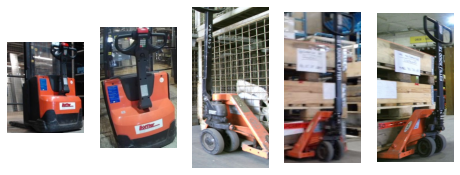

In [12]:
figsize = (8, 8)
fig=plt.figure(figsize=figsize)
columns = len(class_images)
for i, class_image in enumerate(class_images):
    fig.add_subplot(1, columns, i + 1)
    plt.imshow(class_image)
    plt.axis('off')


Show fixed number of detections that are above a certain threshold. Yellow rectangles show detection boxes. Each box has a class label and the detection scores (the higher the better the detection). Red parallelograms illustrate the affine transformations that align class images to the input image at the location of detection.

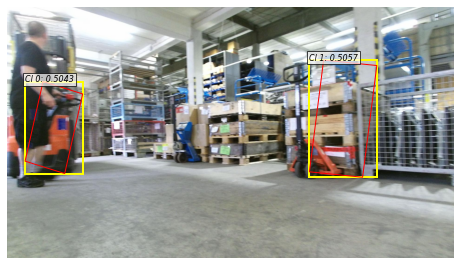

In [14]:
plt.rcParams["figure.figsize"] = figsize

# float("-inf")
cfg.visualization.eval.max_detections = 1000
cfg.visualization.eval.score_threshold = 0.5
visualizer.show_detections(boxes, input_image,
                           cfg.visualization.eval)